In [141]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from scipy.optimize import milp, LinearConstraint, Bounds
from catboost import CatBoostRegressor

In [142]:
def get_fpl_data():
    base_url = "https://fantasy.premierleague.com/api/bootstrap-static/"
    response = requests.get(base_url)
    data = response.json()
    return data

In [143]:
def get_fixtures_df():
    url = "https://fantasy.premierleague.com/api/fixtures/"
    return pd.DataFrame(requests.get(url).json())

fixtures_df = get_fixtures_df()


In [144]:
fpl_data = get_fpl_data()

In [145]:
fpl_data.keys()

dict_keys(['chips', 'events', 'game_settings', 'game_config', 'phases', 'teams', 'total_players', 'element_stats', 'element_types', 'elements'])

In [146]:
teams_data = fpl_data['teams']
players_data = fpl_data['elements']
gameweek_data = fpl_data['events']
chips = fpl_data['chips']
game_config = fpl_data['game_config']

In [147]:
def get_next_gw(gw):
    ev = pd.DataFrame(gw)[["id", "is_next", "is_current", "finished"]].copy()
    if (ev["is_next"] == True).any():
        return int(ev.loc[ev["is_next"] == True, "id"].iloc[0])
    if (ev["is_current"] == True).any():
        return int(ev.loc[ev["is_current"] == True, "id"].iloc[0]) + 1
    if (ev["finished"] == False).any():
        return int(ev.loc[ev["finished"] == False, "id"].min())
    return int(ev["id"].max())

def team_event_fdr(fixtures_df):
    f = fixtures_df.copy()
    f = f.loc[f["event"].notna(), ["event","team_h","team_a","team_h_difficulty","team_a_difficulty"]].copy()
    f["event"] = f["event"].astype(int)

    home = f.rename(columns={"team_h":"team","team_a":"opponent","team_h_difficulty":"fdr"})[["team","event","opponent","fdr"]]
    home["is_home"] = 1
    away = f.rename(columns={"team_a":"team","team_h":"opponent","team_a_difficulty":"fdr"})[["team","event","opponent","fdr"]]
    away["is_home"] = 0

    long = pd.concat([home, away], ignore_index=True)

    out = long.groupby(["team","event"], as_index=False).agg(
        fdr=("fdr","mean"),
        games=("fdr","size"),
        home_games=("is_home","sum"),
    )
    out["away_games"] = out["games"] - out["home_games"]
    return out

In [148]:
def fixtures_long_fdr(fixtures_df):
    f = fixtures_df.loc[fixtures_df["event"].notna(), ["event","team_h","team_a","team_h_difficulty","team_a_difficulty"]].copy()
    f["event"] = f["event"].astype(int)

    home = pd.DataFrame({
        "event": f["event"],
        "team": f["team_h"],
        "opponent_team": f["team_a"],
        "was_home": 1,
        "fdr": f["team_h_difficulty"]
    })
    away = pd.DataFrame({
        "event": f["event"],
        "team": f["team_a"],
        "opponent_team": f["team_h"],
        "was_home": 0,
        "fdr": f["team_a_difficulty"]
    })
    return pd.concat([home, away], ignore_index=True)

fx_long = fixtures_long_fdr(fixtures_df)


In [149]:
mapping = {1: "gk", 2: "def", 3: "mid", 4: "att"}  

In [150]:
print(players_data[1]['chance_of_playing_this_round'])
players_data[0].keys()

None


dict_keys(['can_transact', 'can_select', 'chance_of_playing_next_round', 'chance_of_playing_this_round', 'code', 'cost_change_event', 'cost_change_event_fall', 'cost_change_start', 'cost_change_start_fall', 'dreamteam_count', 'element_type', 'ep_next', 'ep_this', 'event_points', 'first_name', 'form', 'id', 'in_dreamteam', 'news', 'news_added', 'now_cost', 'photo', 'points_per_game', 'removed', 'second_name', 'selected_by_percent', 'special', 'squad_number', 'status', 'team', 'team_code', 'total_points', 'transfers_in', 'transfers_in_event', 'transfers_out', 'transfers_out_event', 'value_form', 'value_season', 'web_name', 'region', 'team_join_date', 'birth_date', 'has_temporary_code', 'opta_code', 'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded', 'own_goals', 'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards', 'saves', 'bonus', 'bps', 'influence', 'creativity', 'threat', 'ict_index', 'clearances_blocks_interceptions', 'recoveries', 'tackles', 'defen

In [151]:
players_data_df = pd.DataFrame(players_data)

In [152]:
players_data_df = players_data_df[['now_cost','total_points', 'element_type', 'goals_scored', 'bps','assists', 'clean_sheets', 'goals_conceded', 'own_goals', 'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards', 'saves', 'influence', 'creativity', 'threat', 'ict_index', 'clearances_blocks_interceptions', 'recoveries', 'tackles', 'defensive_contribution', 'expected_goals', 'expected_assists', 'expected_goal_involvements', 'expected_goals_conceded', 'form', 'starts', 'minutes','web_name', 'team', 'chance_of_playing_this_round']]
players_data_df["element_type"] = players_data_df["element_type"].map(mapping)


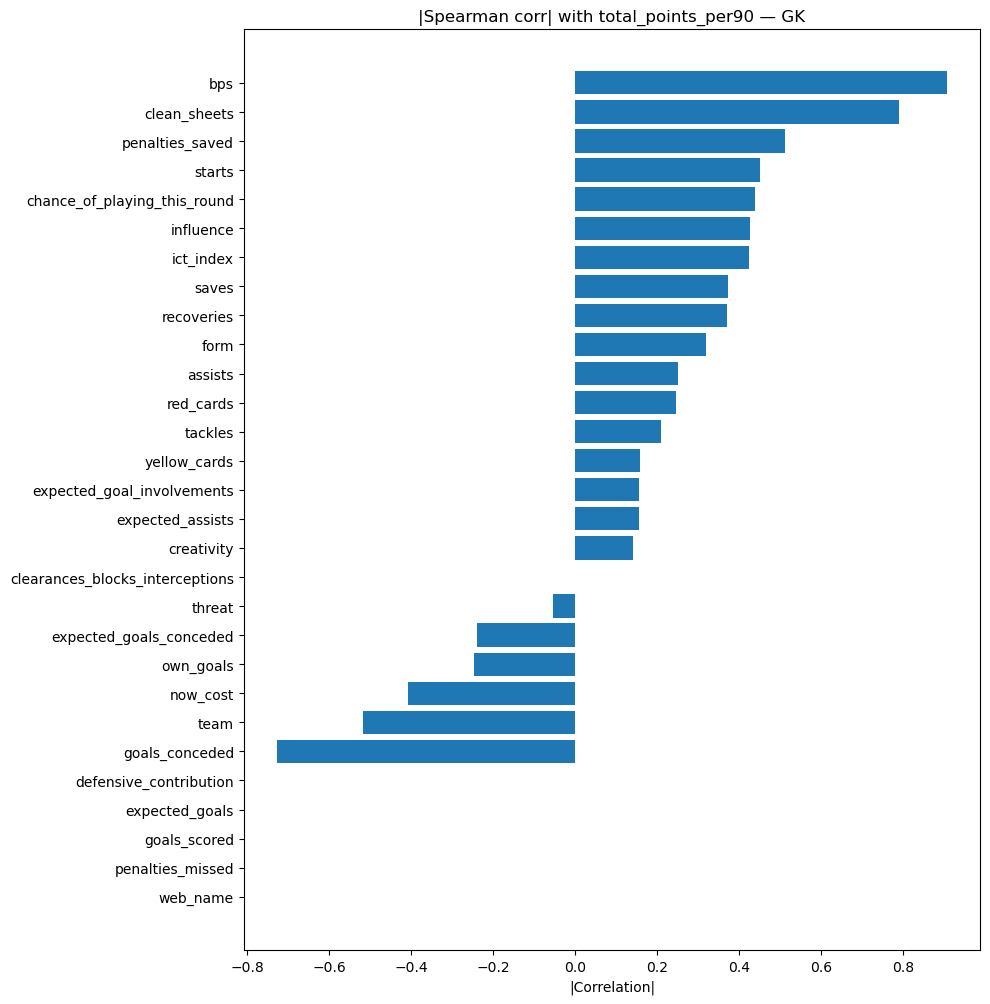

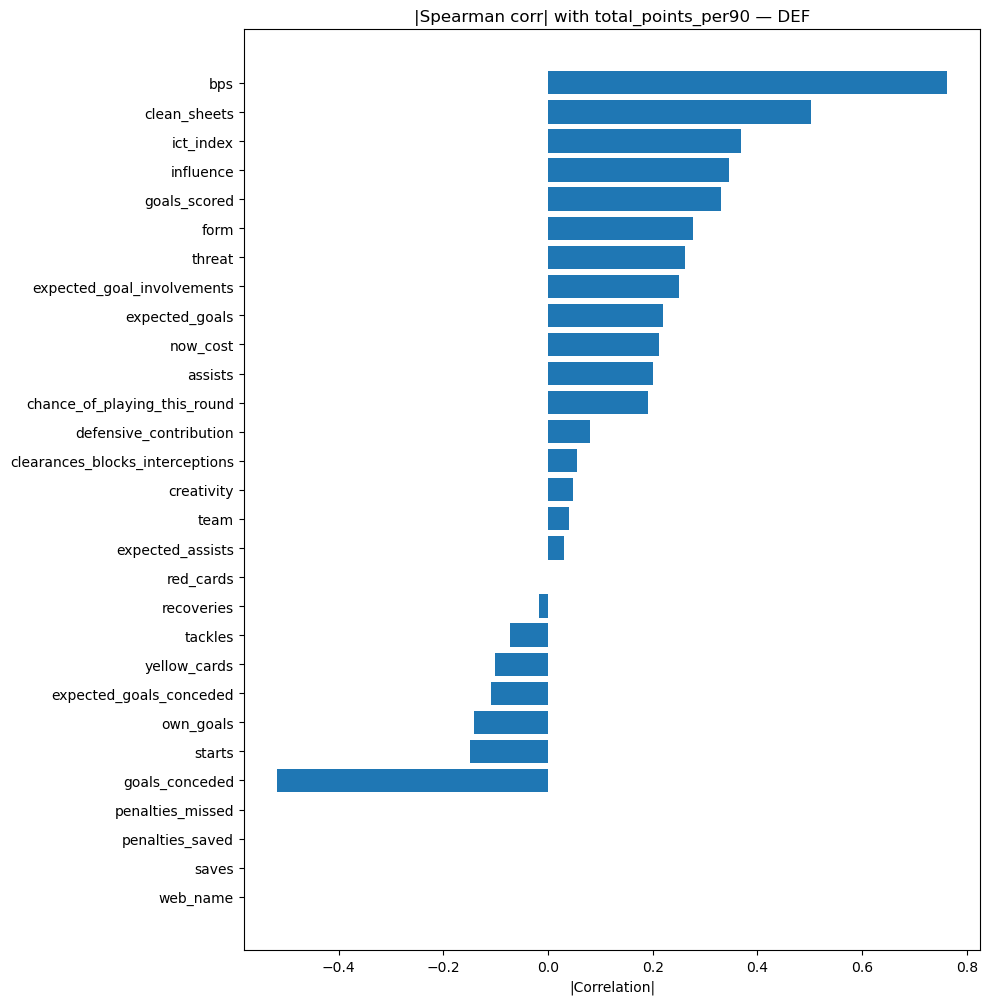

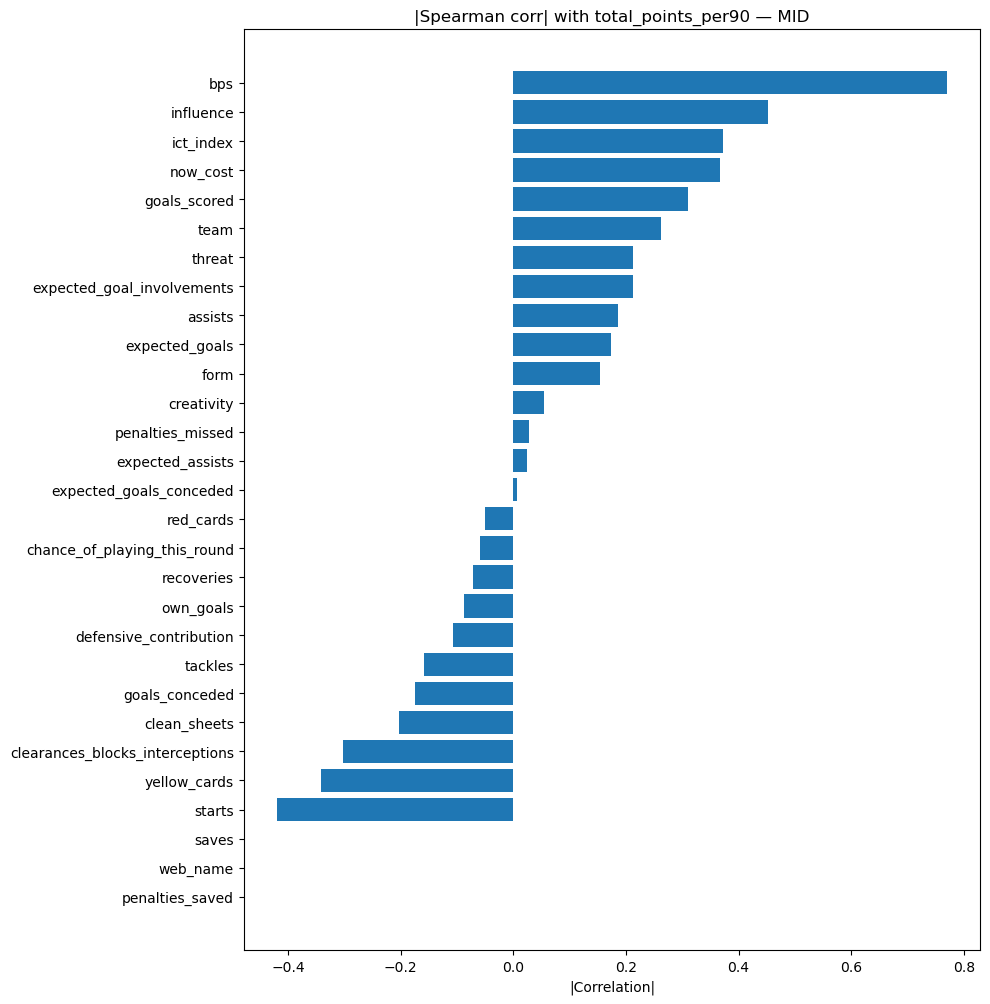

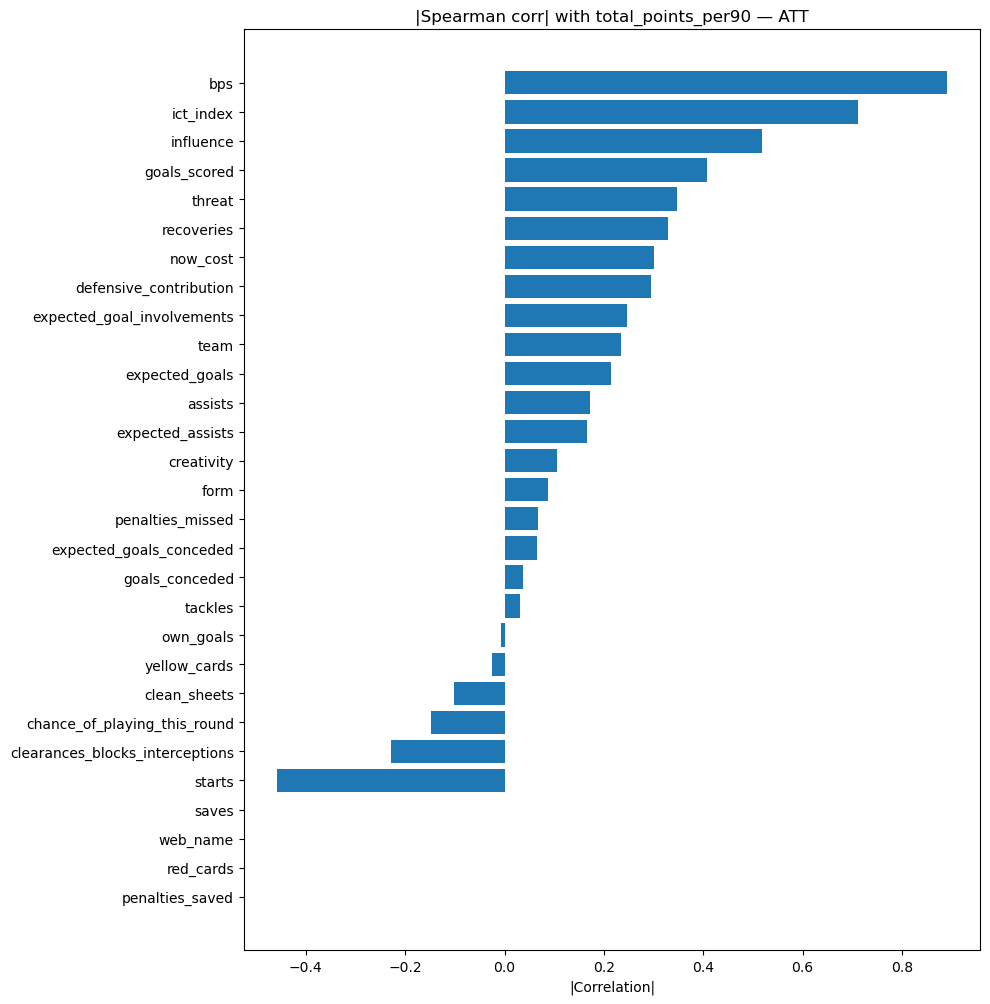

In [153]:
def corr_plots_by_position_per90_abs(
    df: pd.DataFrame,
    group_col: str = "element_type",
    target: str = "total_points",
    minutes_col: str = "minutes",
    positions=("gk", "def", "mid", "att"),
    method: str = "spearman",
):
    d = df.copy()

    for c in d.columns:
        if c != group_col:
            d[c] = pd.to_numeric(d[c], errors="coerce")

    num_cols = d.select_dtypes(include="number").columns
    if target not in num_cols or minutes_col not in num_cols:
        raise ValueError(f"'{target}' and '{minutes_col}' must be numeric columns in df.")

    denom = d[minutes_col].replace(0, np.nan) / 90.0
    per90 = d[num_cols].div(denom, axis=0)
    per90[minutes_col] = d[minutes_col]
    

    features = [c for c in num_cols if c not in (target, minutes_col)]
    corr_df = pd.DataFrame(index=list(positions), columns=features, dtype=float)

    for pos in positions:
        sub = per90.loc[d[group_col] == pos, [target] + features]
        if len(sub) < 2:
            continue

        s = sub.corr(method=method)[target].reindex(features)
    
        s_sorted = s.reindex(s.fillna(-1).sort_values(ascending=False).index).fillna(0)

        plt.figure(figsize=(10, max(4, 0.35 * len(s_sorted))))
        y = np.arange(len(s_sorted))
        plt.barh(y, s_sorted.values)
        plt.yticks(y, s_sorted.index)
        plt.gca().invert_yaxis()
        plt.title(f"|{method.title()} corr| with {target}_per90 — {pos.upper()}")
        plt.xlabel("|Correlation|")
        plt.tight_layout()
        plt.show()

        corr_df.loc[pos] = s

    return corr_df

corr_df = corr_plots_by_position_per90_abs(
    players_data_df,
    group_col="element_type",
    target="total_points",
    minutes_col="minutes",
    method="spearman",
)


In [154]:
def get_target_gw(events, manual=None):
    if manual is not None:
        return int(manual)
    ev = pd.DataFrame(events).copy()
    if "is_next" in ev.columns and (ev["is_next"] == True).any():
        return int(ev.loc[ev["is_next"] == True, "id"].iloc[0])
    if "is_current" in ev.columns and (ev["is_current"] == True).any():
        return int(ev.loc[ev["is_current"] == True, "id"].iloc[0]) + 1
    return int(pd.to_numeric(ev["id"], errors="coerce").max())

## Dynamic FDR

In [155]:
def get_bootstrap():
    return requests.get("https://fantasy.premierleague.com/api/bootstrap-static/").json()

def get_fixtures_df():
    return pd.DataFrame(requests.get("https://fantasy.premierleague.com/api/fixtures/").json())


In [156]:
fpl_data = get_bootstrap()
fixtures_df = get_fixtures_df()

events_data = fpl_data["events"]
teams_data = fpl_data["teams"]
players_data = fpl_data["elements"]

events_df = pd.DataFrame(events_data).copy()
teams_df = pd.DataFrame(teams_data).copy()

players_meta_df = pd.DataFrame(players_data)[
    ["id","web_name","element_type","team","now_cost","chance_of_playing_this_round"]
].copy()

players_meta_df["id"] = pd.to_numeric(players_meta_df["id"], errors="coerce").astype(int)
players_meta_df["element_type"] = pd.to_numeric(players_meta_df["element_type"], errors="coerce").astype(int)
players_meta_df["team"] = pd.to_numeric(players_meta_df["team"], errors="coerce").astype(int)
players_meta_df["now_cost"] = pd.to_numeric(players_meta_df["now_cost"], errors="coerce")
players_meta_df["chance_of_playing_this_round"] = pd.to_numeric(players_meta_df["chance_of_playing_this_round"], errors="coerce")


In [157]:
def update_team_strengths_mle(fixtures_df, ratings_df, upto_gw, b=0.35, home_scale=1.0, base_goals=1.35, lr=0.08, reg=0.10, n_iter=900, decay=0.05, tol=1e-7):
    r = ratings_df.copy()
    team_ids = r["team_id"].astype(int).tolist()
    n = len(team_ids)
    mx = max(team_ids)
    tid2i = np.full(mx + 1, -1, dtype=int)
    tid2i[np.array(team_ids, dtype=int)] = np.arange(n, dtype=int)

    A = (r["att_score"].astype(float).values - 3.0) * b
    D = (r["def_score"].astype(float).values - 3.0) * b
    hm = r.set_index("team_id")["home_modifier"].astype(float).to_dict()

    f = fixtures_df.loc[fixtures_df["event"].notna()].copy()
    f["event"] = pd.to_numeric(f["event"], errors="coerce").astype(int)
    f = f.loc[(f["event"] <= int(upto_gw)) & (f["team_h_score"].notna()) & (f["team_a_score"].notna())]
    if "finished" in f.columns:
        f = f.loc[f["finished"].astype(bool)]
    if len(f) == 0:
        out = r.copy()
        out["att_score"] = out["att_score"].astype(float)
        out["def_score"] = out["def_score"].astype(float)
        return out

    th = f["team_h"].astype(int).values
    ta = f["team_a"].astype(int).values
    gh = f["team_h_score"].astype(float).values
    ga = f["team_a_score"].astype(float).values
    ev = f["event"].astype(int).values

    hi = tid2i[th]
    ai = tid2i[ta]

    ok = (hi >= 0) & (ai >= 0)
    th, ta, gh, ga, ev, hi, ai = th[ok], ta[ok], gh[ok], ga[ok], ev[ok], hi[ok], ai[ok]

    hm_h = np.array([hm[int(t)] for t in th], dtype=float)
    home_term = home_scale * (hm_h - 0.35)

    mu = float(np.log(float(base_goals)))
    last_ll = -1e18

    for _ in range(int(n_iter)):
        if decay and decay > 0:
            w = np.exp(-float(decay) * (float(upto_gw) - ev.astype(float)))
        else:
            w = np.ones_like(gh, dtype=float)

        lam_h = np.exp(mu + A[hi] - D[ai] + home_term)
        lam_a = np.exp(mu + A[ai] - D[hi] - home_term)

        err_h = gh - lam_h
        err_a = ga - lam_a

        ll = float(np.sum(w * (gh * np.log(lam_h + 1e-12) - lam_h + ga * np.log(lam_a + 1e-12) - lam_a)) - 0.5 * reg * (np.sum(A * A) + np.sum(D * D)))
        if abs(ll - last_ll) < tol:
            break
        last_ll = ll

        gA = np.zeros(n, dtype=float)
        gD = np.zeros(n, dtype=float)

        np.add.at(gA, hi, w * err_h)
        np.add.at(gA, ai, w * err_a)

        np.add.at(gD, ai, -w * err_h)
        np.add.at(gD, hi, -w * err_a)

        gmu = float(np.sum(w * (err_h + err_a)))

        gA -= reg * A
        gD -= reg * D

        denom = float(np.sum(w) * 2.0) if float(np.sum(w)) > 0 else float(len(w) * 2.0)

        A = A + (float(lr) / denom) * gA
        D = D + (float(lr) / denom) * gD
        mu = mu + (float(lr) / denom) * gmu

        A = A - float(np.mean(A))
        D = D - float(np.mean(D))

    out = r.copy()
    out["att_score"] = np.clip(3.0 + (A / float(b)), 1.0, 5.0).astype(float)
    out["def_score"] = np.clip(3.0 + (D / float(b)), 1.0, 5.0).astype(float)
    return out

def dynamic_fdr_long(fixtures_df, ratings_df):
    att = dict(zip(ratings_df["team_id"], ratings_df["att_score"]))
    deff = dict(zip(ratings_df["team_id"], ratings_df["def_score"]))
    hm = dict(zip(ratings_df["team_id"], ratings_df["home_modifier"]))

    f = fixtures_df.loc[fixtures_df["event"].notna(), ["id","event","team_h","team_a"]].copy()
    f["event"] = pd.to_numeric(f["event"], errors="coerce").astype(int)

    home = pd.DataFrame({
        "fixture_id": pd.to_numeric(f["id"], errors="coerce").astype(int),
        "event": f["event"].astype(int),
        "team": pd.to_numeric(f["team_h"], errors="coerce").astype(int),
        "opponent_team": pd.to_numeric(f["team_a"], errors="coerce").astype(int),
        "was_home": 1
    })

    away = pd.DataFrame({
        "fixture_id": pd.to_numeric(f["id"], errors="coerce").astype(int),
        "event": f["event"].astype(int),
        "team": pd.to_numeric(f["team_a"], errors="coerce").astype(int),
        "opponent_team": pd.to_numeric(f["team_h"], errors="coerce").astype(int),
        "was_home": 0
    })

    long = pd.concat([home, away], ignore_index=True)

    def clip15(x):
        return int(max(1, min(5, round(float(x), 0))))

    att_fdr = []
    def_fdr = []

    for row in long.itertuples(index=False):
        team = int(row.team)
        opp = int(row.opponent_team)
        if int(row.was_home) == 1:
            m = hm[team]
            att_fdr.append(clip15(deff[opp] - att[team] + 3 - m))
            def_fdr.append(clip15(att[opp] - deff[team] + 3 - m))
        else:
            m = hm[opp]
            att_fdr.append(clip15(deff[opp] - att[team] + 3 + m))
            def_fdr.append(clip15(att[opp] - deff[team] + 3 + m))

    long["att_fdr"] = att_fdr
    long["def_fdr"] = def_fdr
    long["fdr"] = pd.to_numeric(long["att_fdr"], errors="coerce").fillna(3.0)
    return long

def _finished_gw(fixtures_df):
    f = fixtures_df.copy()
    f = f.loc[f["event"].notna()].copy()
    f["event"] = pd.to_numeric(f["event"], errors="coerce")
    ok = f["team_h_score"].notna() & f["team_a_score"].notna()
    if "finished" in f.columns:
        ok = ok & f["finished"].astype(bool)
    x = pd.to_numeric(f.loc[ok, "event"], errors="coerce").dropna()
    return int(x.max()) if len(x) else 0

def team_snapshots_mle(fixtures_df, base_ratings_df, upto_gw):
    snaps = {0: base_ratings_df.copy()}
    r = base_ratings_df.copy()
    for gw in range(1, int(upto_gw) + 1):
        r = update_team_strengths_mle(fixtures_df, r, upto_gw=gw)
        snaps[int(gw)] = r
    return snaps

def fx_long_dynamic(fixtures_df, snapshots):
    f = fixtures_df.loc[fixtures_df["event"].notna(), ["id","event","team_h","team_a"]].copy()
    f["event"] = pd.to_numeric(f["event"], errors="coerce").astype(int)
    last_key = max(snapshots.keys()) if len(snapshots) else 0

    out = []
    for gw in sorted(pd.unique(f["event"])):
        key = int(min(max(gw - 1, 0), last_key))
        ratings = snapshots[key]
        sub = f.loc[f["event"].eq(int(gw)), ["id","event","team_h","team_a"]].copy()
        long = dynamic_fdr_long(sub, ratings)
        out.append(long[["fixture_id","event","team","opponent_team","was_home","fdr","att_fdr","def_fdr"]])

    return pd.concat(out, ignore_index=True) if out else pd.DataFrame(columns=["fixture_id","event","team","opponent_team","was_home","fdr","att_fdr","def_fdr"])


In [158]:
base_ratings = pd.read_csv("team_strengths.csv")

finished_gw = _finished_gw(fixtures_df)
events_df["id"] = pd.to_numeric(events_df["id"], errors="coerce").astype(int)

if "is_next" in events_df.columns and (events_df["is_next"] == True).any():
    target_gw = int(events_df.loc[events_df["is_next"] == True, "id"].iloc[0])
else:
    target_gw = int(finished_gw + 1)

snapshots = team_snapshots_mle(fixtures_df, base_ratings, upto_gw=finished_gw)
fx_long = fx_long_dynamic(fixtures_df, snapshots)


In [159]:
def plot_team_dynamic_fdr(fx_long, teams_df, team_id, gw_start, gw_end, metric="att_fdr"):
    tmap = teams_df.set_index("id")["short_name"].to_dict()
    x = fx_long.loc[fx_long["event"].between(int(gw_start), int(gw_end))].copy()
    x["team"] = pd.to_numeric(x["team"], errors="coerce").astype(int)
    x["opponent_team"] = pd.to_numeric(x["opponent_team"], errors="coerce").astype(int)
    x["event"] = pd.to_numeric(x["event"], errors="coerce").astype(int)
    x["was_home"] = pd.to_numeric(x["was_home"], errors="coerce").astype(int)
    x[metric] = pd.to_numeric(x[metric], errors="coerce")

    x = x.loc[x["team"].eq(int(team_id))].copy()
    if len(x) == 0:
        return

    x["opp_label"] = x["opponent_team"].map(tmap).fillna(x["opponent_team"].astype(str)) + np.where(x["was_home"].eq(1), " (H)", " (A)")
    x = x.sort_values(["event","fixture_id"]).reset_index(drop=True)

    gws = x["event"].to_numpy()
    vals = x[metric].to_numpy(dtype=float)

    xs = gws + np.linspace(-0.15, 0.15, len(x))

    fig = plt.figure(figsize=(12, 4))
    plt.scatter(xs, vals)
    plt.plot(xs, vals)

    for i in range(len(x)):
        plt.text(xs[i], vals[i] + 0.05, x.loc[i, "opp_label"], ha="center", va="bottom", fontsize=9)

    plt.ylim(0.7, 5.3)
    plt.yticks([1,2,3,4,5])
    plt.xticks(range(int(gw_start), int(gw_end) + 1))
    plt.title(f"{teams_df.set_index('id').loc[int(team_id), 'short_name']} {metric} (GW{gw_start}–GW{gw_end})")
    plt.xlabel("Gameweek")
    plt.ylabel("FDR (1 easy → 5 hard)")
    plt.grid(True, axis="y", alpha=0.3)
    plt.show()


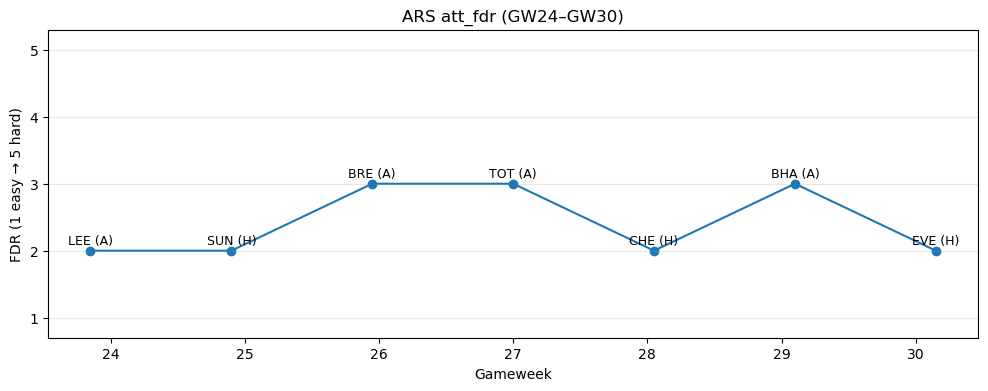

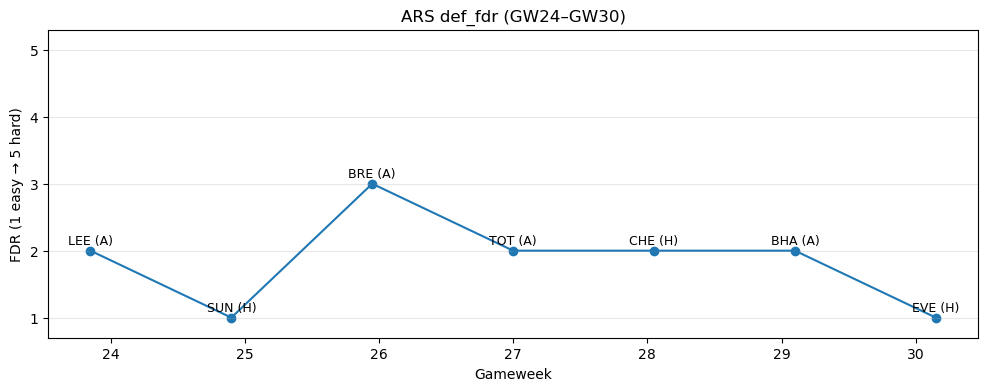

In [160]:
gw_start, gw_end = target_gw, target_gw + 6
plot_team_dynamic_fdr(fx_long, teams_df, team_id=1, gw_start=gw_start, gw_end=gw_end, metric="att_fdr")
plot_team_dynamic_fdr(fx_long, teams_df, team_id=1, gw_start=gw_start, gw_end=gw_end, metric="def_fdr")


In [165]:
def plot_team_dynamic_fdr(fx_long, teams_df, team_id, gw_start, gw_end, metric="att_fdr"):
    from matplotlib.colors import LinearSegmentedColormap

    cmap = LinearSegmentedColormap.from_list(
        "fdr_green_red",
        ["#00A651", "#DCE775", "#FFC107", "#FB8C00", "#D32F2F"],
        N=256
    )

    tmap = teams_df.set_index("id")["short_name"].to_dict()
    x = fx_long.loc[fx_long["event"].between(int(gw_start), int(gw_end))].copy()

    x["team"] = pd.to_numeric(x["team"], errors="coerce").astype(int)
    x["opponent_team"] = pd.to_numeric(x["opponent_team"], errors="coerce").astype(int)
    x["event"] = pd.to_numeric(x["event"], errors="coerce").astype(int)
    x["was_home"] = pd.to_numeric(x["was_home"], errors="coerce").astype(int)
    x[metric] = pd.to_numeric(x[metric], errors="coerce")

    x = x.loc[x["team"].eq(int(team_id))].copy()
    if len(x) == 0:
        return

    x["opp_label"] = x["opponent_team"].map(tmap).fillna(x["opponent_team"].astype(str)) + np.where(x["was_home"].eq(1), " (H)", " (A)")
    x = x.sort_values(["event","fixture_id"]).reset_index(drop=True)

    gws = x["event"].to_numpy()
    vals = x[metric].to_numpy(dtype=float)
    xs = gws + np.linspace(-0.15, 0.15, len(x))

    plt.figure(figsize=(12, 4))
    plt.plot(xs, vals, color="black", alpha=0.35)
    sc = plt.scatter(xs, vals, c=vals, cmap=cmap, vmin=1, vmax=5)

    for i in range(len(x)):
        plt.text(xs[i], vals[i] + 0.06, x.loc[i, "opp_label"], ha="center", va="bottom", fontsize=9)

    plt.ylim(0.7, 5.3)
    plt.yticks([1,2,3,4,5])
    plt.xticks(range(int(gw_start), int(gw_end) + 1))
    plt.title(f"{teams_df.set_index('id').loc[int(team_id), 'short_name']} {metric} (GW{gw_start}–GW{gw_end})")
    plt.xlabel("Gameweek")
    plt.ylabel("FDR (1 easy → 5 hard)")
    plt.grid(True, axis="y", alpha=0.3)

    cbar = plt.colorbar(sc, fraction=0.03, pad=0.02)
    cbar.set_ticks([1,2,3,4,5])
    plt.show()


In [169]:
def ticker_mats_from_fx_long(fx_long, teams_df, gw_start, gw_end, metric="att_fdr", order_by="name"):
    short = teams_df.set_index("id")["short_name"].to_dict()

    x = fx_long.loc[fx_long["event"].between(int(gw_start), int(gw_end))].copy()
    x["team"] = pd.to_numeric(x["team"], errors="coerce").astype(int)
    x["event"] = pd.to_numeric(x["event"], errors="coerce").astype(int)
    x["opponent_team"] = pd.to_numeric(x["opponent_team"], errors="coerce").astype(int)
    x["was_home"] = pd.to_numeric(x["was_home"], errors="coerce").astype(int)
    x[metric] = pd.to_numeric(x[metric], errors="coerce")

    x["opp_label"] = x["opponent_team"].map(short).fillna(x["opponent_team"].astype(str)) + np.where(x["was_home"].eq(1), " (H)", " (A)")

    agg = x.groupby(["team","event"]).agg(
        val=(metric, "mean"),
        label=("opp_label", lambda s: "\n".join(s.tolist()))
    ).reset_index()

    if order_by == "name":
        order = teams_df.sort_values("name")["id"].astype(int).tolist()
    elif order_by == "short_name":
        order = teams_df.sort_values("short_name")["id"].astype(int).tolist()
    else:
        order = teams_df["id"].astype(int).tolist()

    mat = agg.pivot(index="team", columns="event", values="val").reindex(order)
    lab = agg.pivot(index="team", columns="event", values="label").reindex(order)
    return mat, lab

def plot_fdr_ticker(mat, lab_mat, teams_df, title):
    from matplotlib.colors import LinearSegmentedColormap

    cmap = LinearSegmentedColormap.from_list(
        "fdr_green_red",
        ["#00A651", "#DCE775", "#FFC107", "#FB8C00", "#D32F2F"],
        N=256
    )

    teams = teams_df.set_index("id")["short_name"].to_dict()
    y = list(mat.index)
    gws = list(mat.columns)

    data = mat.values.astype(float)
    masked = np.ma.masked_invalid(data)

    fig = plt.figure(figsize=(max(14, 1.25 * len(gws) + 4), max(8, 0.42 * len(y))))
    ax = plt.gca()
    im = ax.imshow(masked, aspect="auto", vmin=1, vmax=5, cmap=cmap)

    ax.set_xticks(np.arange(len(gws)))
    ax.set_xticklabels([f"GW{int(g)}" for g in gws])
    ax.set_yticks(np.arange(len(y)))
    ax.set_yticklabels([teams.get(int(t), str(t)) for t in y])

    for i, team_id in enumerate(y):
        for j, gw in enumerate(gws):
            v = masked[i, j]
            if np.ma.is_masked(v):
                continue
            cell = lab_mat.loc[team_id, gw] if (team_id in lab_mat.index and gw in lab_mat.columns) else ""
            if isinstance(cell, float) and np.isnan(cell):
                cell = ""
            ax.text(j, i, str(cell), ha="center", va="center", fontsize=8)

    ax.set_title(title)
    ax.set_xlabel("Gameweek")
    cbar = fig.colorbar(im, ax=ax, fraction=0.03, pad=0.02)
    cbar.set_label("FDR (1 easy → 5 hard)")
    cbar.set_ticks([1,2,3,4,5])

    ax.set_xticks(np.arange(-.5, len(gws), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(y), 1), minor=True)
    ax.grid(which="minor", linewidth=0.6)
    ax.tick_params(which="minor", bottom=False, left=False)

    plt.tight_layout()
    plt.show()


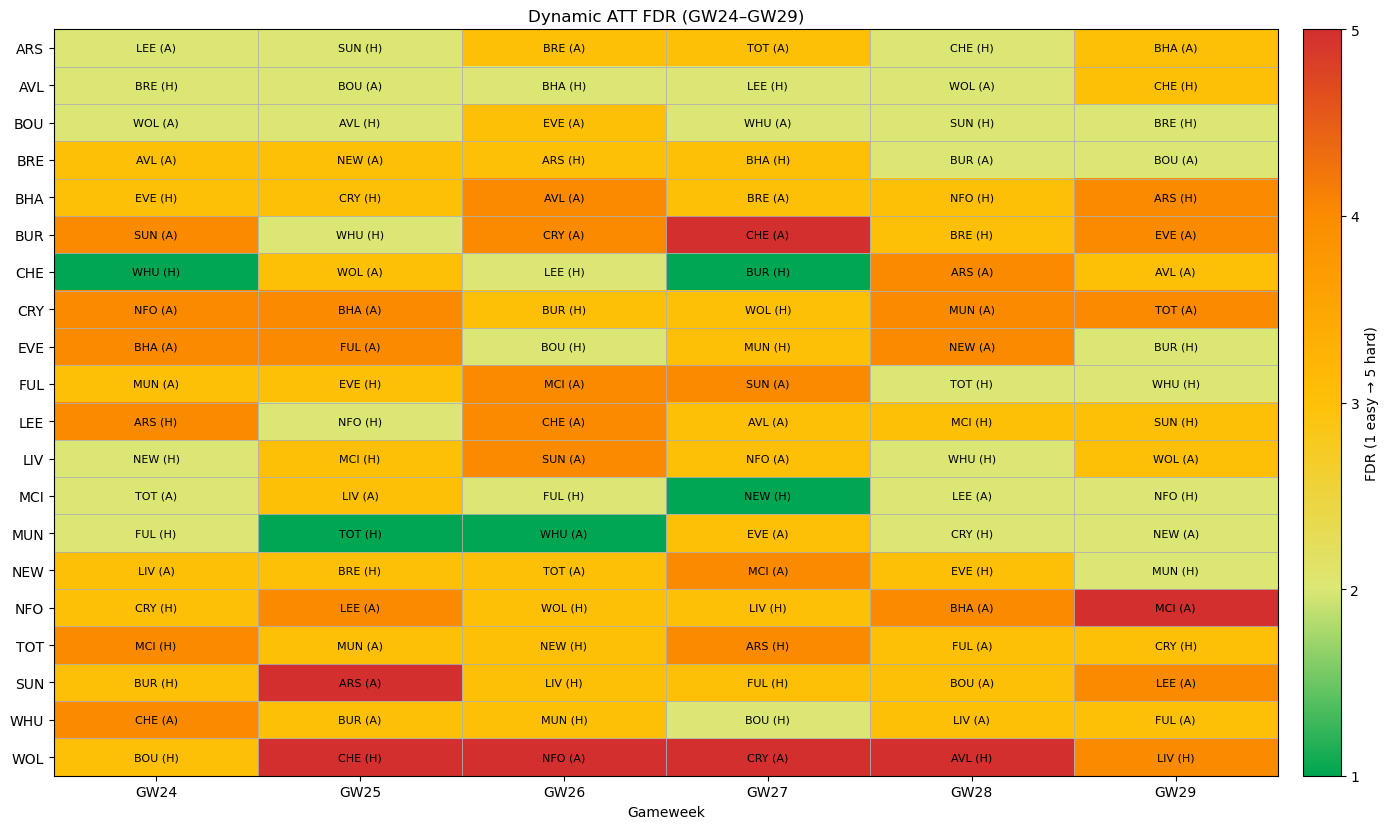

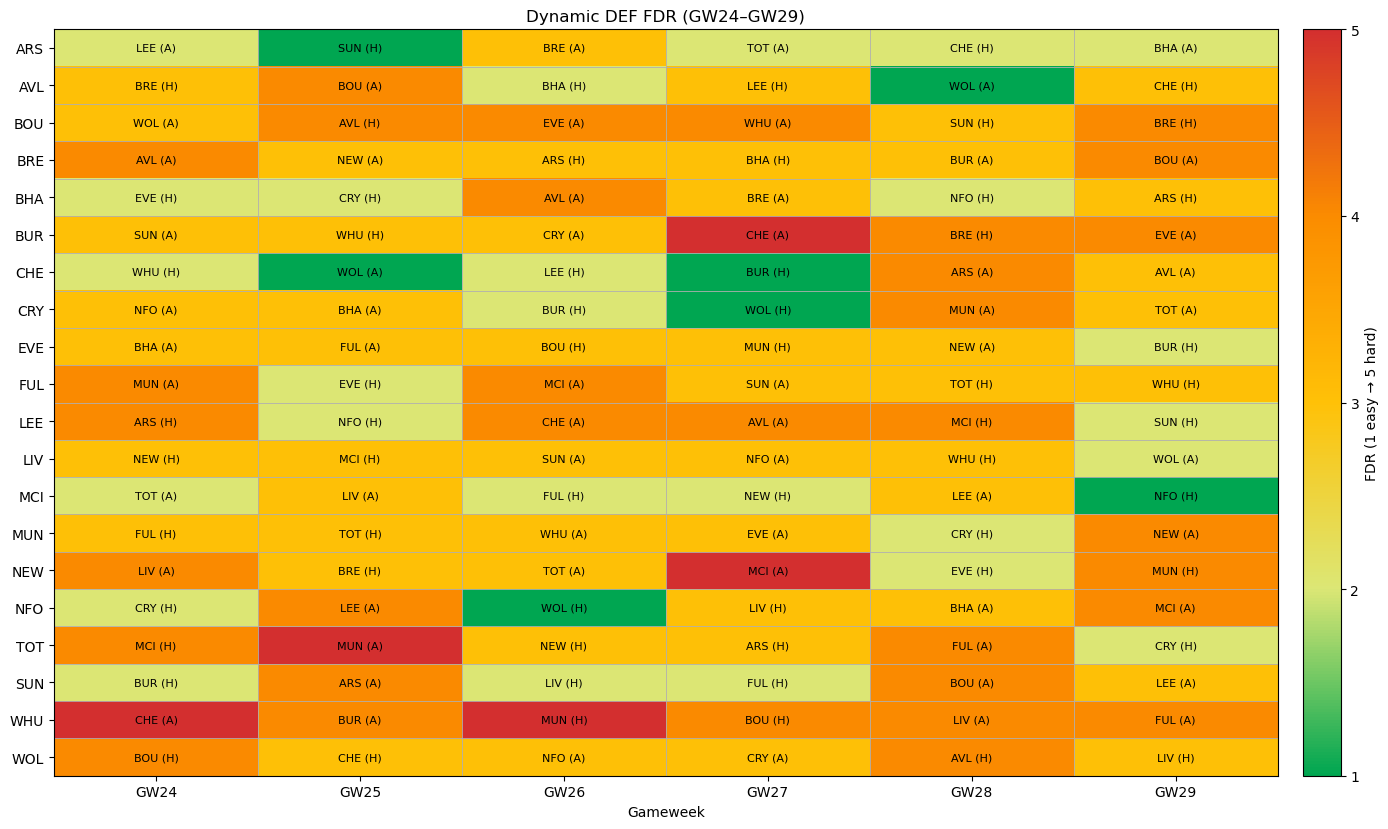

In [170]:
gw_start, gw_end = target_gw, target_gw + 5

att_mat, att_lab = ticker_mats_from_fx_long(fx_long, teams_df, gw_start, gw_end, metric="att_fdr", order_by="name")
plot_fdr_ticker(att_mat, att_lab, teams_df, f"Dynamic ATT FDR (GW{gw_start}–GW{gw_end})")

def_mat, def_lab = ticker_mats_from_fx_long(fx_long, teams_df, gw_start, gw_end, metric="def_fdr", order_by="name")
plot_fdr_ticker(def_mat, def_lab, teams_df, f"Dynamic DEF FDR (GW{gw_start}–GW{gw_end})")


## Data Refresh & Player Metadata Extraction

This section refreshes the FPL API data and extracts key player information for the upcoming gameweek predictions. We retrieve fresh player metadata including ID, name, position, team, cost, and injury status.

In [171]:
def get_element_summary(player_id, session=None):
    s = session or requests.Session()
    url = f"https://fantasy.premierleague.com/api/element-summary/{int(player_id)}/"
    return s.get(url).json()

def build_player_gw_history(players_meta_df, fx_long):
    s = requests.Session()
    rows = []
    for pid in players_meta_df["id"].tolist():
        j = get_element_summary(int(pid), session=s)
        h = pd.DataFrame(j.get("history", []))
        if len(h) == 0:
            continue
        h["id"] = int(pid)
        rows.append(h)

    hist = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()

    keep = [
        "id","round","opponent_team","was_home","total_points","minutes",
        "goals_scored","assists","clean_sheets","goals_conceded","saves",
        "influence","creativity","threat","ict_index","form",
        "expected_goals","expected_assists","expected_goals_conceded",
        "value",
    ]
    keep = [c for c in keep if c in hist.columns]
    hist = hist[keep].copy()

    hist["id"] = pd.to_numeric(hist["id"], errors="coerce").astype(int)

    hist = hist.merge(
        players_meta_df[["id","web_name","element_type","team"]],
        on="id",
        how="left",
    )

    hist["round"] = pd.to_numeric(hist["round"], errors="coerce").astype(int)
    hist["team"] = pd.to_numeric(hist["team"], errors="coerce").astype(int)
    hist["element_type"] = pd.to_numeric(hist["element_type"], errors="coerce").astype(int)
    hist["opponent_team"] = pd.to_numeric(hist["opponent_team"], errors="coerce").astype(int)
    hist["was_home"] = pd.to_numeric(hist["was_home"], errors="coerce").astype(int)

    hist = hist.merge(
        fx_long,
        left_on=["round","team","opponent_team","was_home"],
        right_on=["event","team","opponent_team","was_home"],
        how="left",
    ).drop(columns=["event"])

    hist = hist.rename(columns={"total_points":"gw_points", "value":"now_cost"})
    hist["gw_points"] = pd.to_numeric(hist["gw_points"], errors="coerce")
    hist["now_cost"] = pd.to_numeric(hist["now_cost"], errors="coerce")
    hist["fdr"] = pd.to_numeric(hist["fdr"], errors="coerce").fillna(3.0)
    hist["att_fdr"] = pd.to_numeric(hist["att_fdr"], errors="coerce").fillna(hist["fdr"])
    hist["def_fdr"] = pd.to_numeric(hist["def_fdr"], errors="coerce").fillna(3.0)

    return hist

player_gw_df = build_player_gw_history(players_meta_df, fx_long)


In [172]:
def add_rolling_features(df, group_col="id", time_col="round", windows=(3,), shift=1, cols=None):
    d = df.copy()
    d[time_col] = pd.to_numeric(d[time_col], errors="coerce")
    d = d.sort_values([group_col, time_col])

    if cols is None:
        cols = [
            "minutes","goals_scored","assists","clean_sheets","goals_conceded","saves",
            "expected_goals","expected_assists","expected_goals_conceded",
            "influence","creativity","threat","ict_index","form",
        ]
    cols = [c for c in cols if c in d.columns]
    for c in cols:
        d[c] = pd.to_numeric(d[c], errors="coerce")

    for w in windows:
        rolled = d.groupby(group_col, sort=False)[cols].rolling(w, min_periods=1).mean()
        if shift:
            rolled = rolled.shift(shift)
        rolled = rolled.reset_index(level=0, drop=True)
        rolled.columns = [f"{c}_r{w}" for c in cols]
        d = pd.concat([d, rolled], axis=1)

    return d


In [173]:
window = 3

train_df = add_rolling_features(player_gw_df, windows=(window,), shift=1)
train_df["round"] = pd.to_numeric(train_df["round"], errors="coerce").astype("Int64")

train_df[f"minutes_r{window}"] = pd.to_numeric(train_df.get(f"minutes_r{window}", np.nan), errors="coerce").fillna(0)
train_df["w_min"] = np.clip(train_df[f"minutes_r{window}"] / 90.0, 0, 1)


In [174]:
feature_map_gw = {
    1: ["now_cost","was_home","def_fdr","clean_sheets_r3","goals_conceded_r3","saves_r3","expected_goals_conceded_r3","minutes_r3"],
    2: ["now_cost","was_home","att_fdr","def_fdr","clean_sheets_r3","goals_conceded_r3","assists_r3","goals_scored_r3","expected_goals_r3","expected_assists_r3","expected_goals_conceded_r3","minutes_r3"],
    3: ["now_cost","was_home","att_fdr","assists_r3","goals_scored_r3","expected_goals_r3","expected_assists_r3","ict_index_r3","minutes_r3"],
    4: ["now_cost","was_home","att_fdr","goals_scored_r3","assists_r3","expected_goals_r3","expected_assists_r3","ict_index_r3","minutes_r3"],
}


In [175]:
def make_regressor(model_type="cat", params=None):
    params = params or {}
    if model_type == "xgb":
        base = dict(
            n_estimators=800,
            learning_rate=0.03,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            objective="reg:squarederror",
            random_state=42,
        )
        base.update(params)
        return XGBRegressor(**base)
    if model_type == "cat":
        base = dict(
            loss_function="RMSE",
            iterations=2000,
            learning_rate=0.03,
            depth=7,
            l2_leaf_reg=4.0,
            random_seed=42,
            verbose=False,
        )
        base.update(params)
        return CatBoostRegressor(**base)
    raise ValueError("model_type must be 'xgb' or 'cat'")

def fit_models_by_position_time(
    df,
    feature_map,
    target="gw_points",
    pos_col="element_type",
    round_col="round",
    model_type="cat",
    params=None,
    min_rows=80,
    val_gws=5,
    weight_col=None,
):
    d = df.copy()
    d[pos_col] = pd.to_numeric(d[pos_col], errors="coerce")
    d[round_col] = pd.to_numeric(d[round_col], errors="coerce")
    d[target] = pd.to_numeric(d[target], errors="coerce")

    models = {}
    for pos, feats in feature_map.items():
        sub = d.loc[d[pos_col].eq(int(pos)), feats + [target, round_col]].copy()
        sub = sub.dropna(subset=[target, round_col])
        if len(sub) < min_rows:
            continue

        X = sub[feats].apply(pd.to_numeric, errors="coerce").fillna(0)
        y = sub[target].to_numpy()
        r = sub[round_col].astype(int).to_numpy()

        u = np.unique(r)
        u.sort()
        if len(u) <= val_gws:
            X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.2, random_state=42)
            tr_idx = X_tr.index
            va_idx = X_va.index
        else:
            val_set = set(u[-val_gws:])
            tr_idx = sub.index[~sub[round_col].astype(int).isin(val_set)]
            va_idx = sub.index[sub[round_col].astype(int).isin(val_set)]
            X_tr, y_tr = X.loc[tr_idx], sub.loc[tr_idx, target].to_numpy()
            X_va, y_va = X.loc[va_idx], sub.loc[va_idx, target].to_numpy()

        m = make_regressor(model_type=model_type, params=params)

        if weight_col is None or weight_col not in d.columns:
            if model_type == "cat":
                m.fit(X_tr, y_tr, eval_set=(X_va, y_va), use_best_model=True, early_stopping_rounds=80)
            else:
                m.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)
        else:
            w_all = pd.to_numeric(d.loc[sub.index, weight_col], errors="coerce").fillna(1.0)
            w_tr = w_all.loc[tr_idx].to_numpy(dtype=float)
            w_va = w_all.loc[va_idx].to_numpy(dtype=float)
            if model_type == "cat":
                m.fit(X_tr, y_tr, sample_weight=w_tr, eval_set=(X_va, y_va), use_best_model=True, early_stopping_rounds=80)
            else:
                m.fit(X_tr, y_tr, sample_weight=w_tr, eval_set=[(X_va, y_va)], verbose=False)

        models[int(pos)] = m

    return models

def predict_by_position(pred_df, models, feature_map, pos_col="element_type", pred_col="pred"):
    d = pred_df.copy()
    d[pos_col] = pd.to_numeric(d[pos_col], errors="coerce")
    d[pred_col] = np.nan

    for pos, feats in feature_map.items():
        if int(pos) not in models:
            continue
        sub = d.loc[d[pos_col].eq(int(pos))]
        if len(sub) == 0:
            continue
        X = sub[feats].apply(pd.to_numeric, errors="coerce").fillna(0)
        d.loc[sub.index, pred_col] = models[int(pos)].predict(X)

    return d


In [112]:
# fx_long = fixtures_long_fdr(fixtures_df)
# team_event_df = team_event_fdr(fixtures_df)

In [176]:
def make_pred_frame_for_gw_long(player_gw_df, fx_long, gw, window=3, players_meta_df=None):
    base = player_gw_df.loc[pd.to_numeric(player_gw_df["round"], errors="coerce").astype(int) < int(gw)].copy()
    base = add_rolling_features(base, windows=(window,), shift=0)

    last = base.sort_values(["id","round"]).groupby("id", as_index=False).tail(1).copy()
    roll_cols = [c for c in last.columns if c.endswith(f"_r{window}")]
    core = last[["id","web_name","element_type","team","now_cost"] + roll_cols].copy()

    if players_meta_df is not None:
        pm = players_meta_df[["id","now_cost","chance_of_playing_this_round"]].copy()
        core = core.merge(pm, on="id", how="left", suffixes=("_hist",""))
        core["now_cost"] = pd.to_numeric(core["now_cost"], errors="coerce").fillna(pd.to_numeric(core["now_cost_hist"], errors="coerce"))
        core = core.drop(columns=["now_cost_hist"])

    fx = fx_long.loc[pd.to_numeric(fx_long["event"], errors="coerce").astype(int).eq(int(gw))].copy()
    fx = fx[["team","opponent_team","was_home","fdr","att_fdr","def_fdr"]].copy()

    out = core.merge(fx, on="team", how="left")

    out["fdr"] = pd.to_numeric(out["fdr"], errors="coerce").fillna(3.0)
    out["att_fdr"] = pd.to_numeric(out["att_fdr"], errors="coerce").fillna(out["fdr"])
    out["def_fdr"] = pd.to_numeric(out["def_fdr"], errors="coerce").fillna(3.0)
    out["was_home"] = pd.to_numeric(out["was_home"], errors="coerce").fillna(0).astype(int)

    if "chance_of_playing_this_round" in out.columns:
        out["chance_of_playing_this_round"] = pd.to_numeric(out["chance_of_playing_this_round"], errors="coerce").fillna(100)

    return out

def collapse_fixture_preds(pred_long, pred_col="pred"):
    x = pred_long.copy()
    x[pred_col] = pd.to_numeric(x[pred_col], errors="coerce").fillna(0)
    agg = x.groupby("id", as_index=False).agg(
        gw_score=(pred_col, "sum"),
        games_1=(pred_col, "size"),
    )
    keep = x.drop_duplicates("id")[["id","web_name","element_type","team","now_cost"]].copy()
    out = keep.merge(agg, on="id", how="left").fillna({"gw_score":0, "games_1":0})

    if "chance_of_playing_this_round" in x.columns:
        ch = x.drop_duplicates("id")[["id","chance_of_playing_this_round", "minutes_r3"]].copy()
        ch["chance_of_playing_this_round"] = pd.to_numeric(ch["chance_of_playing_this_round"], errors="coerce").fillna(100)
        ch["minutes_r3"] = pd.to_numeric(ch["minutes_r3"], errors="coerce").fillna(0)
        ch["min_factor"] = np.clip(ch["chance_of_playing_this_round"]/100.0, 0, 1) * np.clip(ch["minutes_r3"]/90.0, 0, 1)
        out = out.merge(ch[["id","min_factor"]], on="id", how="left")
        out["gw_score"] = out["gw_score"] * pd.to_numeric(out["min_factor"], errors="coerce").fillna(1.0)

    return out


In [177]:
def pick_starting_xi(
    df,
    points_col="gw_score",
    cost_col="now_cost",
    pos_col="element_type",
    team_col="team",
    chance_col="chance_of_playing_this_round",
    min_chance=75,
    budget=81.5,
    pos_limits={1: (1, 1), 2: (3, 5), 3: (3, 5), 4: (1, 3)},
    max_from_team=3,
):
    d = df.copy()

    d[points_col] = pd.to_numeric(d[points_col], errors="coerce")
    d[cost_col] = pd.to_numeric(d[cost_col], errors="coerce")
    d[pos_col] = pd.to_numeric(d[pos_col], errors="coerce")

    if chance_col in d.columns:
        d[chance_col] = pd.to_numeric(d[chance_col], errors="coerce").fillna(100)
    else:
        d[chance_col] = 100

    d = d.dropna(subset=[points_col, cost_col, pos_col, team_col]).reset_index(drop=True)
    d = d.loc[d[chance_col].ge(min_chance)].reset_index(drop=True)

    cost_is_tenths = d[cost_col].max() > 25
    costs = d[cost_col].to_numpy(dtype=float)
    B = budget * 10 if cost_is_tenths else float(budget)

    if cost_is_tenths:
        costs = np.round(costs).astype(int)
        B = int(round(B))

    points = d[points_col].to_numpy(dtype=float)
    n = len(d)

    c = -points
    integrality = np.ones(n, dtype=int)
    bounds = Bounds(0, 1)

    rows, lb, ub = [], [], []

    rows.append(np.ones(n)); lb.append(11); ub.append(11)
    rows.append(costs.astype(float)); lb.append(-np.inf); ub.append(B)

    pos_arr = d[pos_col].astype(int).to_numpy()
    for pos, (mn, mx) in pos_limits.items():
        mask = (pos_arr == int(pos)).astype(float)
        rows.append(mask); lb.append(mn); ub.append(mx)

    team_arr = d[team_col].to_numpy()
    for t in pd.unique(team_arr):
        mask = (team_arr == t).astype(float)
        rows.append(mask); lb.append(-np.inf); ub.append(max_from_team)

    A = np.vstack(rows)
    constraints = LinearConstraint(A, lb, ub)

    res = milp(c=c, integrality=integrality, bounds=bounds, constraints=constraints)
    if res.status != 0:
        raise RuntimeError(res.message)

    chosen = res.x > 0.5
    return d.loc[chosen].copy()


In [186]:
pos_map = {1: "GK", 2: "DEF", 3: "MID", 4: "FWD"}
team_map = teams_df.set_index("id")["short_name"].to_dict()

opp_df = pred_long[["id","opponent_team","was_home"]].copy()
opp_df["opponent_team"] = pd.to_numeric(opp_df["opponent_team"], errors="coerce").astype("Int64")
opp_df["was_home"] = pd.to_numeric(opp_df["was_home"], errors="coerce").fillna(0).astype(int)
opp_df["opp"] = opp_df["opponent_team"].map(team_map).fillna(opp_df["opponent_team"].astype(str)) + np.where(opp_df["was_home"].eq(1), " (H)", " (A)")
opp_agg = opp_df.groupby("id", as_index=False).agg(opponents=("opp", lambda s: " / ".join(s.tolist())))

xi_pretty = xi.copy()
xi_pretty["pos"] = xi_pretty["element_type"].map(pos_map)
xi_pretty["team_name"] = xi_pretty["team"].map(team_map)

xi_pretty["now_cost"] = pd.to_numeric(xi_pretty["now_cost"], errors="coerce")
if xi_pretty["now_cost"].max() > 25:
    xi_pretty["cost_m"] = (xi_pretty["now_cost"] / 10).round(1)
else:
    xi_pretty["cost_m"] = xi_pretty["now_cost"].round(1)

xi_pretty["gw_score"] = pd.to_numeric(xi_pretty["gw_score"], errors="coerce").fillna(0).round(2)
xi_pretty["games_1"] = pd.to_numeric(xi_pretty.get("games_1", 1), errors="coerce").fillna(1).astype(int)

xi_pretty = xi_pretty.merge(opp_agg, on="id", how="left")
xi_pretty["opponents"] = xi_pretty["opponents"].fillna("")

xi_pretty = xi_pretty.sort_values("gw_score", ascending=False).reset_index(drop=True)
xi_pretty["role"] = ""
xi_pretty.loc[xi_pretty.index[0], "role"] = "C"
xi_pretty.loc[xi_pretty.index[1], "role"] = "VC"

xi_pretty = xi_pretty.sort_values(
    by=["pos","gw_score"],
    ascending=[True, False],
    key=lambda s: s.map({"GK":0,"DEF":1,"MID":2,"FWD":3}) if s.name=="pos" else s
).reset_index(drop=True)

xi_pretty[["pos","web_name","team_name","opponents","role","cost_m","games_1","gw_score"]]


,pos,web_name,team_name,opponents,role,cost_m,games_1,gw_score
0,GK,Roefs,SUN,BUR (H),,5.0,1,4.97
1,DEF,Gabriel,ARS,LEE (A),C,6.9,1,7.00
2,DEF,Lacroix,CRY,NFO (A),,5.1,1,5.64
3,DEF,Saliba,ARS,LEE (A),,6.0,1,5.08
4,DEF,Cash,AVL,BRE (H),,4.8,1,4.92
5,DEF,Martinez,MUN,FUL (H),,4.8,1,4.86
6,MID,Rogers,AVL,BRE (H),VC,7.7,1,6.67
7,MID,Semenyo,MCI,TOT (A),,7.8,1,5.61
8,MID,Gibbs-White,NFO,CRY (H),,7.3,1,5.23
9,MID,Schade,BRE,AVL (A),,7.2,1,4.25


In [179]:
def actual_points_by_player_gw(player_gw_df, gw):
    x = player_gw_df.loc[pd.to_numeric(player_gw_df["round"], errors="coerce").astype(int).eq(int(gw)), ["id","gw_points"]].copy()
    x["gw_points"] = pd.to_numeric(x["gw_points"], errors="coerce").fillna(0)
    return x.groupby("id", as_index=False).agg(gw_points=("gw_points","sum"))

def xi_actual_points(player_gw_df, xi, gw):
    act = actual_points_by_player_gw(player_gw_df, gw)
    z = xi.merge(act, on="id", how="left")
    return float(pd.to_numeric(z["gw_points"], errors="coerce").fillna(0).sum())

def backtest_model_vs_avg_entry(
    model_type,
    player_gw_df,
    train_df,
    feature_map,
    fx_long,
    events_data,
    start_gw=2,
    end_gw=None,
    window=3,
    budget=81.5,
):
    ev = pd.DataFrame(events_data)[["id","average_entry_score"]].copy()
    ev["id"] = pd.to_numeric(ev["id"], errors="coerce").astype(int)
    ev["average_entry_score"] = pd.to_numeric(ev["average_entry_score"], errors="coerce")
    avg_map = dict(zip(ev["id"], ev["average_entry_score"]))

    if end_gw is None:
        end_gw = int(pd.to_numeric(player_gw_df["round"], errors="coerce").max())

    rows = []
    for gw in range(int(start_gw), int(end_gw) + 1):
        baseline = avg_map.get(gw, np.nan)
        if pd.isna(baseline) or baseline <= 0:
            continue

        tr = train_df.loc[pd.to_numeric(train_df["round"], errors="coerce").astype(int) < int(gw)].copy()
        if len(tr) < 500:
            continue

        models = fit_models_by_position_time(
            tr,
            feature_map,
            target="gw_points",
            pos_col="element_type",
            round_col="round",
            model_type=model_type,
            val_gws=5,
            weight_col="w_min" if "w_min" in tr.columns else None,
        )

        pred_long = make_pred_frame_for_gw_long(player_gw_df, fx_long, gw, window=window, players_meta_df=players_meta_df)
        pred_long = predict_by_position(pred_long, models, feature_map, pos_col="element_type", pred_col="pred")
        pred_df = collapse_fixture_preds(pred_long, pred_col="pred")

        xi = pick_starting_xi(pred_df, points_col="gw_score", budget=budget, min_chance=1)
        xi_act = xi_actual_points(player_gw_df, xi, gw)

        rows.append({
            "gw": gw,
            "model": model_type,
            "xi_actual": xi_act,
            "avg_entry_score": float(baseline),
            "diff_vs_avg_entry": xi_act - float(baseline),
        })

    return pd.DataFrame(rows)


In [ ]:
start_gw = 2
end_gw = int(pd.to_numeric(player_gw_df["round"], errors="coerce").max())

progress_cat = backtest_model_vs_avg_entry(
    "cat",
    player_gw_df=player_gw_df,
    train_df=train_df,
    feature_map=feature_map_gw,
    fx_long=fx_long,
    events_data=events_data,
    start_gw=start_gw,
    end_gw=end_gw,
    window=window,
    budget=81.5,
)

progress_xgb = backtest_model_vs_avg_entry(
    "xgb",
    player_gw_df=player_gw_df,
    train_df=train_df,
    feature_map=feature_map_gw,
    fx_long=fx_long,
    events_data=events_data,
    start_gw=start_gw,
    end_gw=end_gw,
    window=window,
    budget=81.5,
)



,gw,model,xi_actual,avg_entry_score,diff_vs_avg_entry
39,19,xgb,39.0,40.0,-1.0
40,20,xgb,43.0,42.0,1.0
41,21,xgb,40.0,48.0,-8.0
42,22,xgb,38.0,40.0,-2.0
43,23,xgb,38.0,44.0,-6.0


In [183]:
# pd.concat([progress_cat, progress_xgb], ignore_index=True)
progress_cat

,gw,model,xi_actual,avg_entry_score,diff_vs_avg_entry
0,2,cat,30.0,51.0,-21.0
1,3,cat,38.0,48.0,-10.0
2,4,cat,52.0,63.0,-11.0
3,5,cat,52.0,42.0,10.0
4,6,cat,73.0,46.0,27.0
5,7,cat,33.0,60.0,-27.0
6,8,cat,32.0,56.0,-24.0
7,9,cat,39.0,46.0,-7.0
8,10,cat,48.0,65.0,-17.0
9,11,cat,37.0,38.0,-1.0


## Walk-Forward Backtest

In [129]:
import matplotlib.pyplot as plt

In [130]:
def make_regressor(model_type="xgb", params=None):
    params = params or {}
    if model_type == "xgb":
        base = dict(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            objective="reg:squarederror",
            random_state=42,
        )
        base.update(params)
        return XGBRegressor(**base)
    if model_type == "cat":
        base = dict(
            loss_function="RMSE",
            iterations=1500,
            learning_rate=0.05,
            depth=6,
            l2_leaf_reg=3.0,
            random_seed=42,
            verbose=False,
        )
        base.update(params)
        return CatBoostRegressor(**base)
    raise ValueError("model_type must be 'xgb' or 'cat'")

def fit_models_by_position(df, feature_map, target="gw_points", pos_col="element_type", model_type="xgb", params=None, min_rows=50):
    d = df.copy()
    d[pos_col] = pd.to_numeric(d[pos_col], errors="coerce")
    d[target] = pd.to_numeric(d[target], errors="coerce")

    models = {}
    for pos, feats in feature_map.items():
        sub = d.loc[d[pos_col].eq(pos), feats + [target]].copy()
        sub = sub.dropna(subset=[target])
        if len(sub) < min_rows:
            continue

        X = sub[feats].apply(pd.to_numeric, errors="coerce").fillna(0)
        y = sub[target].to_numpy()

        X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.2, random_state=42)

        m = make_regressor(model_type=model_type, params=params)

        if model_type == "cat":
            m.fit(X_tr, y_tr, eval_set=(X_va, y_va), use_best_model=True, early_stopping_rounds=50)
        else:
            m.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)

        models[pos] = m

    return models

def predict_by_position(
    pred_df,
    models,
    feature_map,
    pos_col="element_type",
    pred_col="pred",
):
    d = pred_df.copy()
    d[pos_col] = pd.to_numeric(d[pos_col], errors="coerce")
    d[pred_col] = np.nan

    for pos, feats in feature_map.items():
        if pos not in models:
            continue
        sub = d.loc[d[pos_col].eq(pos)]
        if len(sub) == 0:
            continue
        X = sub[feats].apply(pd.to_numeric, errors="coerce").fillna(0)
        d.loc[sub.index, pred_col] = models[pos].predict(X)

    return d


In [131]:
def team_event_fdr(fixtures_df):
    f = fixtures_df.loc[fixtures_df["event"].notna(), ["event","team_h","team_a","team_h_difficulty","team_a_difficulty"]].copy()
    f["event"] = pd.to_numeric(f["event"], errors="coerce").astype(int)

    home = f.rename(columns={"team_h":"team","team_a":"opponent","team_h_difficulty":"fdr"})[["team","event","opponent","fdr"]]
    away = f.rename(columns={"team_a":"team","team_h":"opponent","team_a_difficulty":"fdr"})[["team","event","opponent","fdr"]]

    long = pd.concat([home, away], ignore_index=True)
    out = long.groupby(["team","event"], as_index=False).agg(
        fdr=("fdr","mean"),
        games=("fdr","size")
    )
    out["fdr"] = pd.to_numeric(out["fdr"], errors="coerce").fillna(3.0)
    out["games"] = pd.to_numeric(out["games"], errors="coerce").fillna(0).astype(int)
    return out

team_event_df = team_event_fdr(fixtures_df)


In [132]:
def make_pred_frame_for_gw(player_gw_df, team_event_df, gw, window=3):
    base = player_gw_df.loc[pd.to_numeric(player_gw_df["round"], errors="coerce").astype(int) < int(gw)].copy()
    base = add_rolling_features(base, windows=(window,), shift=0)

    last = base.sort_values(["id","round"]).groupby("id", as_index=False).tail(1).copy()
    roll_cols = [c for c in last.columns if c.endswith(f"_r{window}")]

    pred_df = last[["id","web_name","element_type","team","now_cost"] + roll_cols].copy()

    te = team_event_df.loc[team_event_df["event"].eq(int(gw)), ["team","fdr","games"]].copy()
    te = te.rename(columns={"fdr":"fdr_1","games":"games_1"})
    pred_df = pred_df.merge(te, on="team", how="left")

    pred_df["fdr_1"] = pd.to_numeric(pred_df["fdr_1"], errors="coerce").fillna(3.0)
    pred_df["games_1"] = pd.to_numeric(pred_df["games_1"], errors="coerce").fillna(0).astype(int)

    pred_df["fdr"] = pred_df["fdr_1"]
    return pred_df

def actual_points_by_player_gw(player_gw_df, gw):
    x = player_gw_df.loc[pd.to_numeric(player_gw_df["round"], errors="coerce").astype(int).eq(int(gw)), ["id","gw_points"]].copy()
    x["gw_points"] = pd.to_numeric(x["gw_points"], errors="coerce").fillna(0)
    return x.groupby("id", as_index=False).agg(gw_points=("gw_points","sum"))

def xi_actual_points(player_gw_df, xi, gw):
    act = actual_points_by_player_gw(player_gw_df, gw)
    z = xi.merge(act, on="id", how="left")
    return float(pd.to_numeric(z["gw_points"], errors="coerce").fillna(0).sum())


In [133]:
def backtest_model_vs_avg_entry(
    model_type,
    player_gw_df,
    train_df,
    feature_map,
    team_event_df,
    events_data,
    start_gw=2,
    end_gw=None,
    window=3,
    budget=81.5,
    model_params=None,
):
    ev = pd.DataFrame(events_data)[["id","average_entry_score"]].copy()
    ev["id"] = pd.to_numeric(ev["id"], errors="coerce").astype(int)
    ev["average_entry_score"] = pd.to_numeric(ev["average_entry_score"], errors="coerce")
    avg_map = dict(zip(ev["id"], ev["average_entry_score"]))

    if end_gw is None:
        end_gw = int(pd.to_numeric(player_gw_df["round"], errors="coerce").max())

    rows = []
    for gw in range(int(start_gw), int(end_gw) + 1):
        baseline = avg_map.get(gw, np.nan)
        if pd.isna(baseline) or baseline <= 0:
            continue

        tr = train_df.loc[pd.to_numeric(train_df["round"], errors="coerce").astype(int) < int(gw)].copy()
        if len(tr) < 500:
            continue

        models = fit_models_by_position(
            tr, feature_map, target="gw_points", pos_col="element_type",
            model_type=model_type, params=model_params
        )

        pred_df = make_pred_frame_for_gw(player_gw_df, team_event_df, gw, window=window)
        pred_df = predict_by_position(pred_df, models, feature_map, pos_col="element_type", pred_col="pred")
        pred_df["gw_score"] = pd.to_numeric(pred_df["pred"], errors="coerce").fillna(0) * pd.to_numeric(pred_df["games_1"], errors="coerce").fillna(0)

        xi = pick_starting_xi(pred_df, points_col="gw_score", budget=budget)
        xi_act = xi_actual_points(player_gw_df, xi, gw)

        rows.append({
            "gw": gw,
            "model": model_type,
            "xi_actual": xi_act,
            "avg_entry_score": float(baseline),
            "diff_vs_avg_entry": xi_act - float(baseline),
        })

    return pd.DataFrame(rows)

start_gw = 2
end_gw = int(pd.to_numeric(player_gw_df["round"], errors="coerce").max())
window = 3

progress_xgb = backtest_model_vs_avg_entry(
    "xgb",
    player_gw_df=player_gw_df,
    train_df=train_df,
    feature_map=feature_map_gw,
    team_event_df=team_event_df,
    events_data=events_data,
    start_gw=start_gw,
    end_gw=end_gw,
    window=window,
    budget=81.5
)

progress_cat = backtest_model_vs_avg_entry(
    "cat",
    player_gw_df=player_gw_df,
    train_df=train_df,
    feature_map=feature_map_gw,
    team_event_df=team_event_df,
    events_data=events_data,
    start_gw=start_gw,
    end_gw=end_gw,
    window=window,
    budget=81.5
)

progress_all = pd.concat([progress_xgb, progress_cat], ignore_index=True)
progress_all.head()


,gw,model,xi_actual,avg_entry_score,diff_vs_avg_entry
0,2,xgb,16.0,51.0,-35.0
1,3,xgb,42.0,48.0,-6.0
2,4,xgb,34.0,63.0,-29.0
3,5,xgb,30.0,42.0,-12.0
4,6,xgb,49.0,46.0,3.0


In [134]:
pivot = progress_all.pivot(index="gw", columns="model", values="diff_vs_avg_entry").dropna()

wins_xgb = int((pivot["xgb"] > pivot["cat"]).sum()) if {"xgb","cat"}.issubset(pivot.columns) else np.nan
wins_cat = int((pivot["cat"] > pivot["xgb"]).sum()) if {"xgb","cat"}.issubset(pivot.columns) else np.nan

summary = pd.DataFrame({
    "model": ["xgb","cat"],
    "gws_tested": [len(progress_xgb), len(progress_cat)],
    "mean_diff": [progress_xgb["diff_vs_avg_entry"].mean(), progress_cat["diff_vs_avg_entry"].mean()],
    "median_diff": [progress_xgb["diff_vs_avg_entry"].median(), progress_cat["diff_vs_avg_entry"].median()],
    "wins_vs_other": [wins_xgb, wins_cat],
})
summary


,model,gws_tested,mean_diff,median_diff,wins_vs_other
0,xgb,22,-8.863636,-9.0,8
1,cat,22,-7.409091,-6.5,12


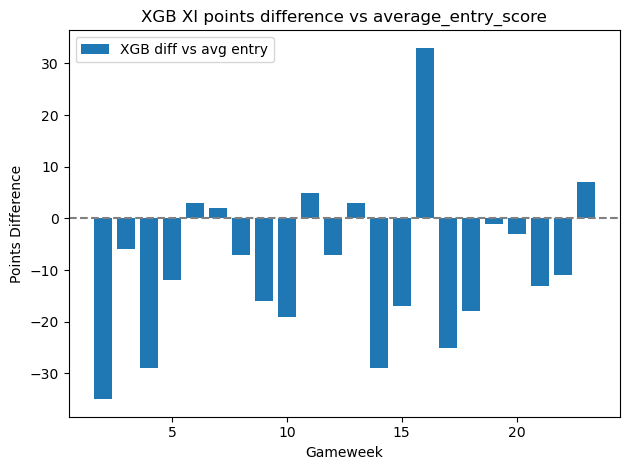

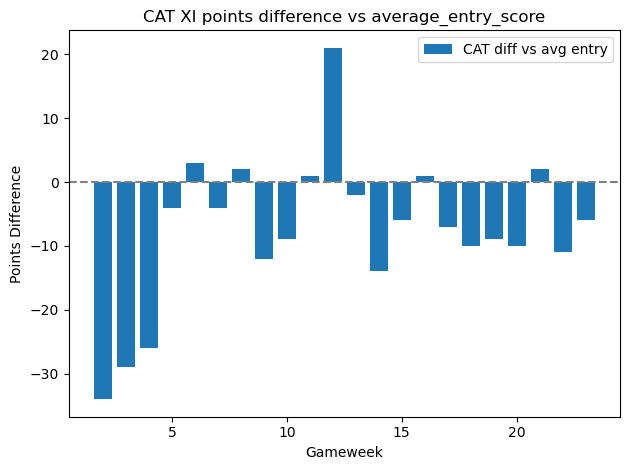

In [135]:
for m in ["xgb", "cat"]:
    dd = progress_all.loc[progress_all["model"].eq(m)].sort_values("gw").copy()

    plt.figure()
    plt.bar(dd["gw"], dd["diff_vs_avg_entry"], label=f"{m.upper()} diff vs avg entry")
    plt.axhline(0, color="gray", linestyle="--")
    plt.xlabel("Gameweek")
    plt.ylabel("Points Difference")
    plt.title(f"{m.upper()} XI points difference vs average_entry_score")
    plt.legend()
    plt.tight_layout()
    plt.show()
